<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

# <font size="5"> G2Net Gravitational Wave Detection - Attempt

<font size="2"> Projeto final da eletiva "Big Data and Astroinformatics" ministrada pelo Profº Drº Clécio R. De Bom.

**Contact:** caroline.fonseca.sodre@gmail.com </font>

In [1]:
# Importing basics libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Training Data Analysis

In [2]:
# Reading training_labels.csv (contains the labels for each given training sample)

training_labels = pd.read_csv("D:/Downloads/Big Data Project/training_labels/training_labels.csv/training_labels.csv")

In [3]:
training_labels.shape

(560000, 2)

In [4]:
display(training_labels.head())

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


Text(0.5, 1.0, 'Data Distribution')

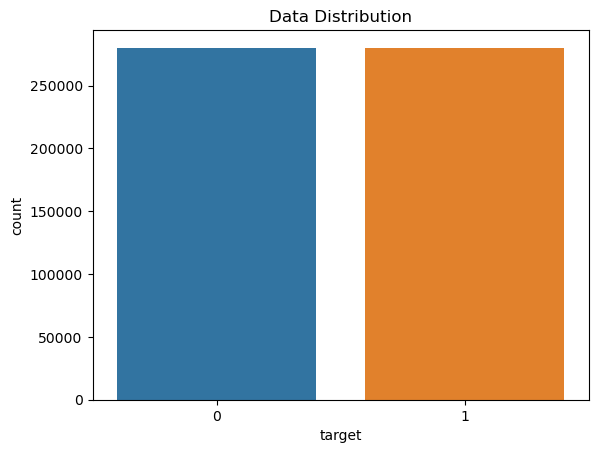

In [5]:
# Exploring the data

sns.countplot(data=training_labels, x="target") # Show the counts of observations in each categorical bin using bars.
plt.title("Data Distribution")

We have 560000 training observations: approximately half of them containing only detector noise (target == 0) and the other half containing detector noise plus a simulated gravitational wave signal (target ==1.).


Let's choose random samples of each type in order to  visualise them in a graphical plot. To do this, we're going to need the path of each sample. Looking at each file, we notice that the name of each sample already contains the name of the folder where the file is located. Therefore, we can define:

In [6]:
# Adding a new column to the table with the path of each file

train_path = ["D:/Downloads/Big Data Project/train/" + "/".join(id[:3]) + "/" + id + ".npy" for id in training_labels.id.values]

training_labels['path'] = train_path 
display(training_labels.head())

,id,target,path
0,00000e74ad,1,D:/Downloads/Big Data Project/train/0/0/0/0000...
1,00001f4945,0,D:/Downloads/Big Data Project/train/0/0/0/0000...
2,0000661522,0,D:/Downloads/Big Data Project/train/0/0/0/0000...
3,00007a006a,0,D:/Downloads/Big Data Project/train/0/0/0/0000...
4,0000a38978,1,D:/Downloads/Big Data Project/train/0/0/0/0000...


In [7]:
# Choosing a random target == 0 sample

rtraining_sample_0_path = np.random.choice(training_labels[training_labels.target == 0].path) 
rtraining_sample_0_id = rtraining_sample_0_path[-14:-4]
print("The chosen target == 0 sample was:\n",rtraining_sample_0_id)

The chosen target == 0 sample was:
 db004c93cc


In [8]:
# Choosing a random target == 1 sample

rtraining_sample_1_path = np.random.choice(training_labels[training_labels.target == 1].path) 
rtraining_sample_1_id = rtraining_sample_1_path[-14:-4]
print("The chosen target == 1 sample was:\n",rtraining_sample_1_id)

The chosen target == 1 sample was:
 4fc5b2beaa


In [9]:
# Loading the files

rtraining_sample_0 = np.load(rtraining_sample_0_path)
rtraining_sample_1 = np.load(rtraining_sample_1_path)
print("The shape of the samples is", rtraining_sample_0.shape)

The shape of the samples is (3, 4096)


We have 3 columns, one for each interferometer, and each spans 2 sec and is sampled at 2,048 Hz.

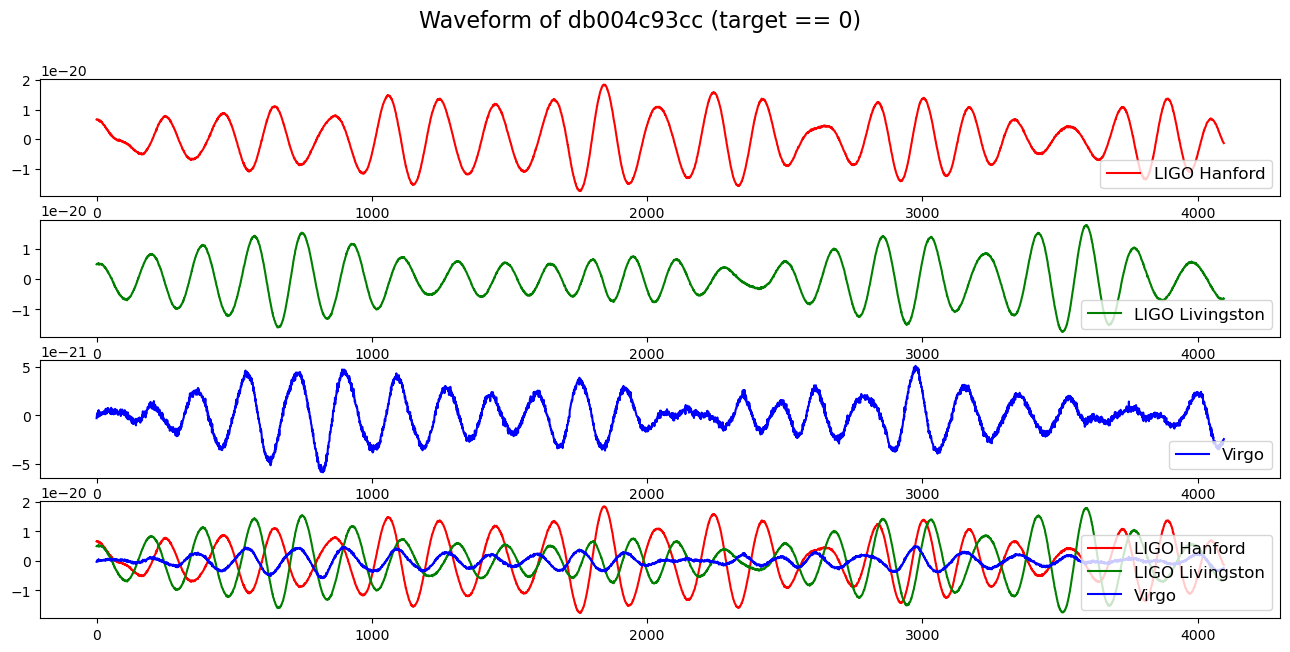

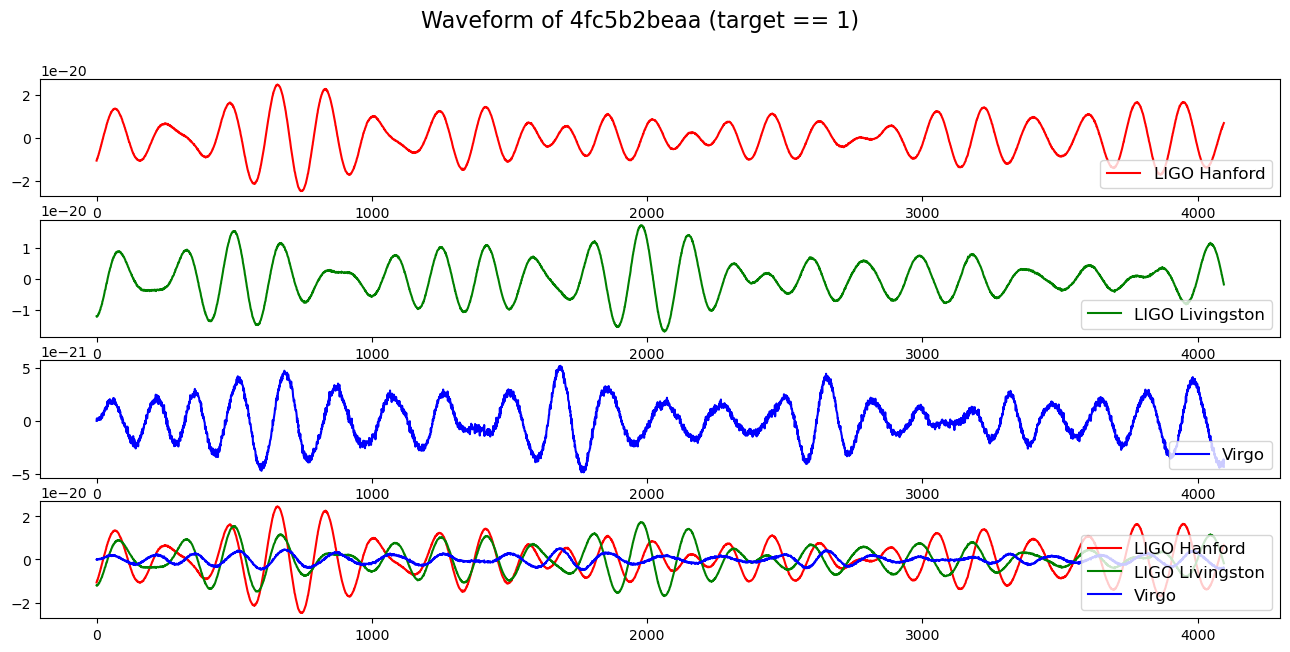

In [10]:
# Plotting the chosen random samples

interferometers = ['LIGO Hanford', 'LIGO Livingston', 'Virgo']
colors = ['red', 'green', 'blue']

random_training_ids = [rtraining_sample_0_id, rtraining_sample_1_id]
random_training_paths = [rtraining_sample_0_path, rtraining_sample_1_path]
random_training_samples = [rtraining_sample_0, rtraining_sample_1]


for i, sample in enumerate(random_training_samples):
    plt.figure(figsize=(16, 7))
    for j in range(3):
        plt.subplot(4, 1, j + 1)
        plt.plot(sample[j], color=colors[j])
        plt.legend([interferometers[j]], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(sample[j], color=colors[j])
        plt.legend(interferometers, fontsize=12, loc="lower right")
        
    plt.suptitle(f"Waveform of {random_training_ids[i]} (target == {i})",fontsize=16)
    plt.show()

Our strategy is to use Constant Q-Transform (which is a transform to the frequency domain with geometrically spaced frequency bins) to extract information and derive features and EfficientNet (which is a family of convolutional neural networks) for classification. The spectrogram of the wave signals are computed with the Constant Q Transform algorthim offered by nnAudio module (CQT1992v2 function).

## Spectrogram

In [11]:
!pip install -q nnAudio

In [12]:
import torch
from nnAudio.features import CQT1992v2

In [13]:
# Building the transformation function

# CQT1992v2 parameters:
    # sr: The sampling rate for the input audio. (From the description of the 
        # data, we have sr = 2,048 Hz)
    # fmin, fmax: The frequency for the lowest/highest CQT bin. (We assume 
        # fmin=20 and fmax=1024)
    # hop_length: The hop (or stride) size. (We assume hop_length=64)
    
def spectrogram(signal_path, Transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)):
    
    signal = np.load(signal_path) # Load the sample
    signal = np.hstack(signal) # Stack arrays in sequence horizontally
    signal = signal / np.max(signal) # Normalize the data
    signal = torch.Tensor(signal) # Constructs a tensor
    CQT_img_2D = Transform(signal) # Transforms the data to the frequency domain (2D)
    CQT_img_3D = np.stack([CQT_img_2D,CQT_img_2D,CQT_img_2D],axis = -1)[0] 
    # Transforms the data in 3D repeating each value 3 times
    
    return CQT_img_3D

C:\Users\carol\anaconda3\lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


CQT kernels created, time used = 0.2798 seconds


This method takes the single sample and horizontally stacks the signals of the three differenct detectors into a single vector and computes the spectrogram. The idea behind stacking all signals in a sample horizontally is that a given sample whose target is 1 corresponding to presence of gravitational wave will have similar repeating frequencies along some given time intervals in the spectrogram.

In [14]:
spectrogram(rtraining_sample_0_path).shape

(69, 193, 3)

The shape of the input data we're going to insert in our EfficientNet model is (69,193,3) - 3D, as it should be.

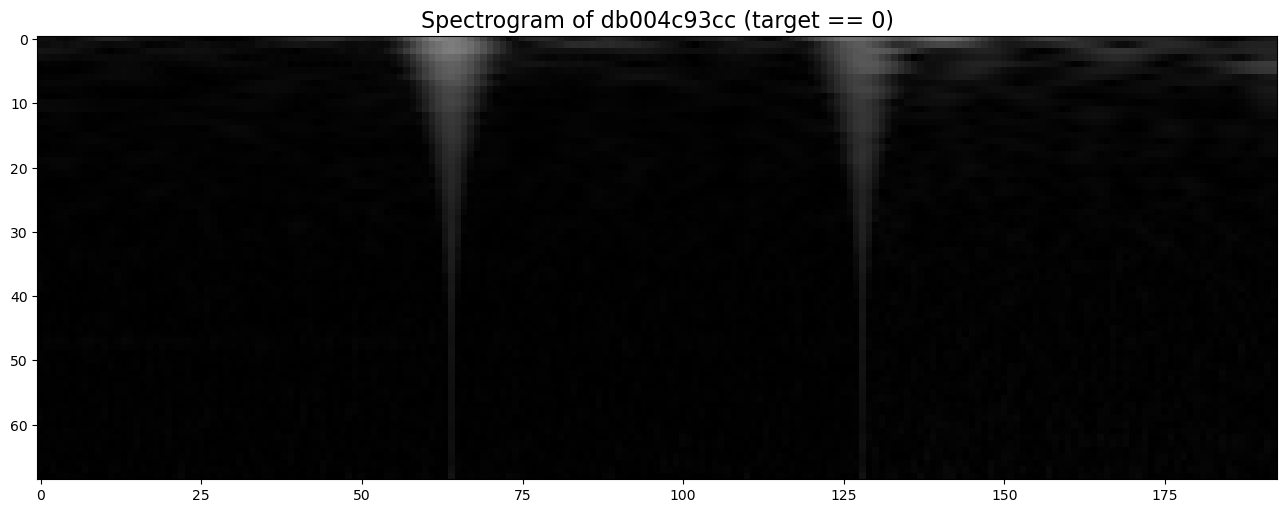

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


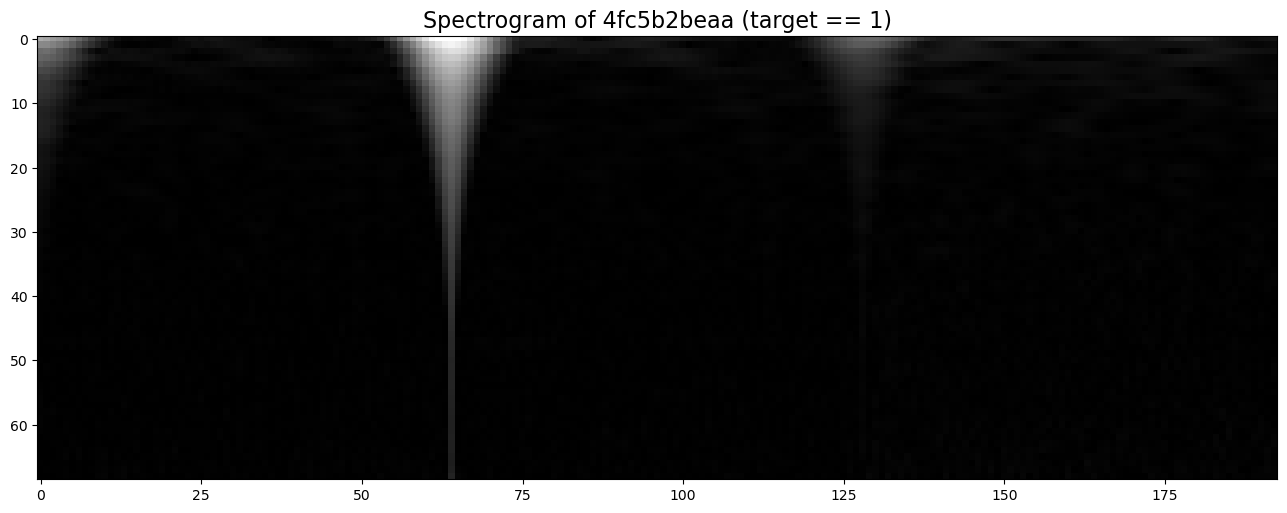

In [15]:
# Plotting some spectrograms

for i, sample in enumerate(random_training_paths):
    cqt_img = spectrogram(sample)
    plt.figure(figsize=(16, 7))
    plt.imshow(cqt_img) # Display data as an image
    plt.title(f"Spectrogram of {random_training_ids[i]} (target == {i})",fontsize=16)
    plt.show()

The next step is to create a Data Generator class. It will help us load the huge dataset we have whitout running out of memory. We will divide the data into batches and load each batch into the ram when we need it. 

## DataGenerator

In [16]:
import tensorflow as tf
import keras
import keras.layers as L
from keras.utils import Sequence
from sklearn.model_selection import train_test_split

In [17]:
class DataGenerator(Sequence): # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
        # Generates data for Keras
        
        def __init__(self, sample_path, sample_target=None, batch_size=128, shuffle=True):
            self.sample_path = sample_path # Sample path
            self.batch_size = batch_size # Number of samples that are passed to the network at once.
            self.shuffle = shuffle # This method changes the position of the elements of the sequence
        
            if sample_target is not None: # So that we can use it for both train and test samples
                self.is_train=True
            else:
                self.is_train=False
                
            self.sample_target = sample_target # Sample target
        
        def __len__(self): # Denotes the number of batches per epoch
            n_batches = math.ceil(len(self.sample_path)/self.batch_size)
            return n_batches
        
        def __getitem__(self, index): # Generate batch_size sample and target at position index

            batch_sample_path = self.sample_path[index * self.batch_size:(index + 1) * self.batch_size]
            batch_sample_spectrogram = np.array([spectrogram(x) for x in batch_sample_path]) # Gets each path in batch_sample_path and feeds spectrogram function
            batch_sample = np.stack(batch_sample_spectrogram) # Stacks the array in sequence horizontally
            
            if self.sample_target is not None: # So that we can use it for both train and test samples
                batch_target = self.sample_target[index * self.batch_size: (index + 1) * self.batch_size]
                return batch_sample,batch_target
            
            else:
                return batch_sample

In [18]:
# Let's split our data into random train and validation subsets using the train_test_split function:

training_path = training_labels['path'].values
training_target = training_labels['target'].values

# train_test_split parameters:
    # test_size: Represent the proportion of the dataset to include in the validation split
    # random_state: Controls the shuffling applied to the data before applying the split. 
    # stratify: If not None, data is split in a stratified fashion, using this as the class labels.

train_path, valid_path, train_target, valid_target = train_test_split(training_path,training_target,test_size=0.2,random_state=42,stratify=training_target)


# Calling DataGenerator
train_dataset = DataGenerator(train_path,train_target)
valid_dataset = DataGenerator(valid_path,valid_target)

Now that we have our train and validation datasets ready to be used, it's time to build our model! For this purpose we are going to use Keras, a deep learning API written in Python running on top of Tensorflow. In order to build our neural network we will use the Sequential API (a linear stack of layers), creating the model layer-by-layer. Our goal is to achieve good results with a simple architecture with the help of EfficientNet.

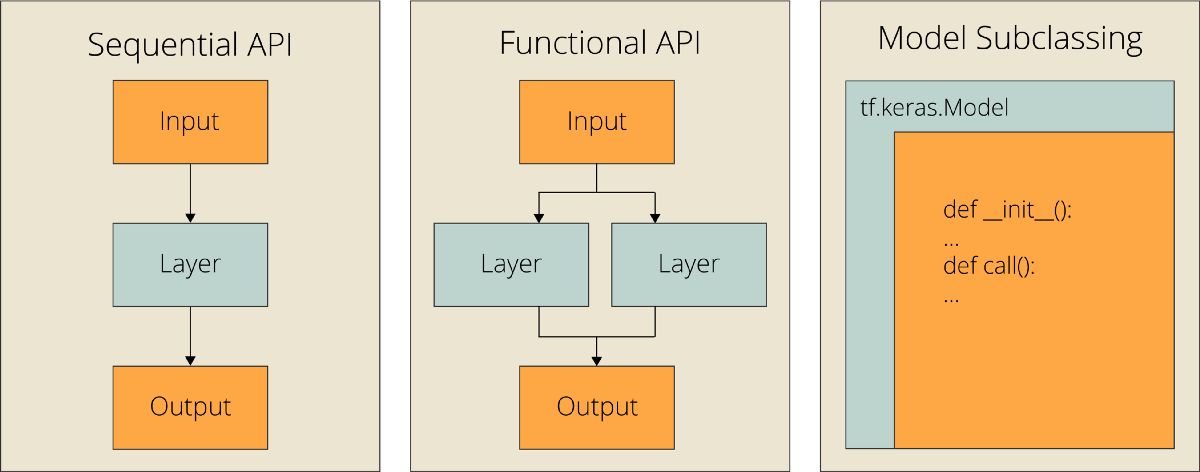

Functional API is more flexible than the sequential API. It is also more powerful in the sense branching or sharing of layers is allowed here since you can define each layer separately and independently. Also, it can have multiple inputs and outputs.

Keras also provides an object-oriented approach to creating models, the Model Subclassing, which helps with reusability and allows you to represent the models you want to create as classes. This representation might be more intuitive since you can think about models as a set of layers strung together to form your network. Model subclassing is fully-customizable and enables you to implement your own custom forward-pass of the model, but is way harder to utilize than the Sequential API or Functional API.

## Model

In [19]:
!pip install -U efficientnet

In [20]:
import efficientnet.keras as efn

We're going to use a typical transfer learning workflow available on the link:

https://keras.io/guides/transfer_learning/#:~:text=The%20typical%20transfer%2Dlearning%20workflow

In [21]:
base_model = efn.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(69,193,3),
    include_top=False)  # Do not include the ImageNet classifier at the top. 
# This option excludes the final Dense layer that turns 1280 features on the 
# penultimate layer into prediction of the 1000 ImageNet classes. 
# Replacing the top layer with custom layers allows using EfficientNet as a 
# feature extractor in a transfer learning workflow.

base_model.trainable = False # Freeze the base model

# Create a new model on top

model = tf.keras.Sequential([
    L.InputLayer(input_shape=(69,193,3)), # Input layer
    base_model, # EfficientNetB0
    L.GlobalAveragePooling2D(), # Global Average Pooling is an operation that 
# calculates the average output of each feature map in the previous layer. 
# This fairly simple operation reduces the data significantly and prepares 
# the model for the final classification layer. It also has no trainable parameters.
# Transforms a 4D tensor with shape (batch_size, rows, cols, channels) 
# into a 2D tensor with shape (batch_size, channels).
    L.Dense(1,activation='sigmoid')])# Output layer

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
# Optimizer: Optimizers are used to adjust input weights, by comparing prediction and the loss function. 
# Accuracy: Calculates the percentage of predicted values that match actual values.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 3, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


The loss function tells how good your model is in predictions. If the model predictions are closer to the actual values the Loss will be minimum and if the predictions are totally away from the original values the loss value will be the maximum.

Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value. 

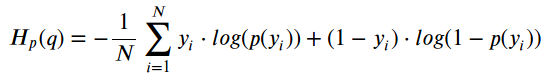

Here, y represents the label / class (0 or 1), and p(y) represents the predicted probability of the data point being 1 for all N data points.

In [24]:
# Training our model (base model freezed)

history = model.fit(train_dataset,batch_size=128,epochs=3,validation_data=valid_dataset, verbose=1)

# Epoch: The total number of iterations of all the training data in one cycle 
    # for training the machine learning model.
# Batch Size: Number of samples processed through to the network at one time.
# Verbose: How you want to see the output of your Nural Network while it's training. 
model.save_weights("model_v3_1.hdf5")
history_logger = keras.callbacks.CSVLogger('history_v3_1.csv', separator=",", append=True)

Epoch 1/3
3500/3500 [==============================] - 29412s 8s/step - loss: 0.6844 - accuracy: 0.5403 - val_loss: 0.6765 - val_accuracy: 0.5673
Epoch 2/3
3500/3500 [==============================] - 27120s 8s/step - loss: 0.6757 - accuracy: 0.5602 - val_loss: 0.6703 - val_accuracy: 0.5813
Epoch 3/3
3500/3500 [==============================] - 26581s 8s/step - loss: 0.6718 - accuracy: 0.5672 - val_loss: 0.6713 - val_accuracy: 0.5740


In [26]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# Training our model (base model unfreezed)
history = model.fit(train_dataset,batch_size=128,epochs=3,validation_data=valid_dataset, verbose=1)
model.save_weights("model_v3_2.hdf5")
history_logger = keras.callbacks.CSVLogger('history_v3_2.csv', separator=",", append=True)

Epoch 1/3
3500/3500 [==============================] - 32934s 9s/step - loss: 0.6353 - accuracy: 0.6431 - val_loss: 0.5380 - val_accuracy: 0.7137
Epoch 2/3
3500/3500 [==============================] - 32689s 9s/step - loss: 0.5214 - accuracy: 0.7265 - val_loss: 0.4978 - val_accuracy: 0.7443
Epoch 3/3
3500/3500 [==============================] - 32293s 9s/step - loss: 0.4921 - accuracy: 0.7482 - val_loss: 0.4812 - val_accuracy: 0.7558


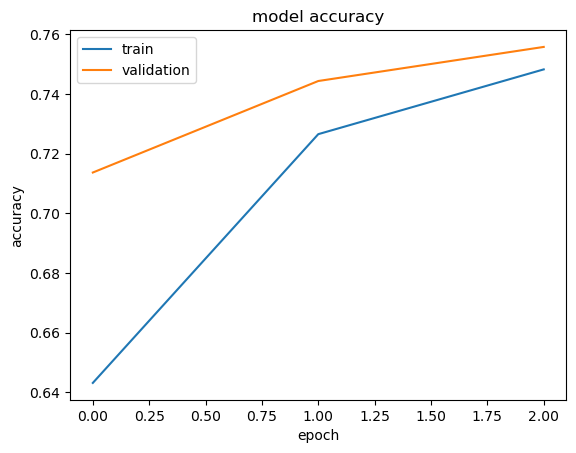

In [28]:
def plot_hist(hist):
    plt.plot(history.history2["accuracy"])
    plt.plot(history.history2["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

## Test Data Analysis

In [29]:
# Reading sample_submission.csv (contains the labels for each given test sample)
test_labels = pd.read_csv("D:/Downloads/Big Data Project/sample_submission.csv")

In [30]:
test_labels.shape

(226000, 2)

In [31]:
display(test_labels.head())

,id,target
0,00005bced6,0.5
1,0000806717,0.5
2,0000ef4fe1,0.5
3,00020de251,0.5
4,00024887b5,0.5


In [32]:
test_path = ["D:/Downloads/Big Data Project/test/" + "/".join(id[:3]) + "/" + id + ".npy" for id in test_labels.id.values]

# Adding a new column to the table
test_labels['path'] = test_path
display(test_labels.head())

,id,target,path
0,00005bced6,0.5,D:/Downloads/Big Data Project/test/0/0/0/00005...
1,0000806717,0.5,D:/Downloads/Big Data Project/test/0/0/0/00008...
2,0000ef4fe1,0.5,D:/Downloads/Big Data Project/test/0/0/0/0000e...
3,00020de251,0.5,D:/Downloads/Big Data Project/test/0/0/0/00020...
4,00024887b5,0.5,D:/Downloads/Big Data Project/test/0/0/0/00024...


In [33]:
# Calling DataGenerator
test_dataset = DataGenerator(test_path)

## Predicting 

In [34]:
predictions = model.predict(test_dataset, verbose=1)

1766/1766 [==============================] - 3857s 2s/step


In [35]:
predictions

array([[0.9999068 ],
       [0.5470784 ],
       [0.4226014 ],
       ...,
       [0.41343555],
       [0.98543656],
       [0.22372632]], dtype=float32)

In [36]:
predictions = predictions.reshape(-1)

In [37]:
final_results = pd.DataFrame({'id':test_labels['id'],'target':predictions})

In [38]:
display(final_results.head())

,id,target
0,00005bced6,0.999907
1,0000806717,0.547078
2,0000ef4fe1,0.422601
3,00020de251,0.374081
4,00024887b5,0.334409
